# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.exclude_past, max_distance=2)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 3641 substitutions for model Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.exclude_past, max_distance=2)


  0% (   1 of 3641) |                      | Elapsed Time: 0:00:04 ETA:  4:45:58

  1% (  46 of 3641) |                      | Elapsed Time: 0:00:05 ETA:  0:01:12

  2% (  92 of 3641) |                      | Elapsed Time: 0:00:06 ETA:  0:00:48

  3% ( 137 of 3641) |                      | Elapsed Time: 0:00:07 ETA:  0:00:59

  5% ( 183 of 3641) |#                     | Elapsed Time: 0:00:08 ETA:  0:00:59

  6% ( 228 of 3641) |#                     | Elapsed Time: 0:00:09 ETA:  0:01:02

  7% ( 274 of 3641) |#                     | Elapsed Time: 0:00:09 ETA:  0:01:00

  8% ( 319 of 3641) |#                     | Elapsed Time: 0:00:10 ETA:  0:00:57

 10% ( 365 of 3641) |##                    | Elapsed Time: 0:00:11 ETA:  0:00:51

 11% ( 410 of 3641) |##                    | Elapsed Time: 0:00:12 ETA:  0:00:54

 12% ( 456 of 3641) |##                    | Elapsed Time: 0:00:12 ETA:  0:00:51

 13% ( 501 of 3641) |###                   | Elapsed Time: 0:00:13 ETA:  0:00:46

 15% ( 547 of 3641) |###                   | Elapsed Time: 0:00:13 ETA:  0:00:38

 16% ( 592 of 3641) |###                   | Elapsed Time: 0:00:14 ETA:  0:00:36

 17% ( 638 of 3641) |###                   | Elapsed Time: 0:00:14 ETA:  0:00:33

 18% ( 683 of 3641) |####                  | Elapsed Time: 0:00:15 ETA:  0:00:31

 20% ( 729 of 3641) |####                  | Elapsed Time: 0:00:15 ETA:  0:00:32

 21% ( 774 of 3641) |####                  | Elapsed Time: 0:00:16 ETA:  0:00:27

 22% ( 820 of 3641) |####                  | Elapsed Time: 0:00:17 ETA:  0:00:28

 23% ( 865 of 3641) |#####                 | Elapsed Time: 0:00:17 ETA:  0:00:27

 25% ( 911 of 3641) |#####                 | Elapsed Time: 0:00:18 ETA:  0:00:28

 26% ( 956 of 3641) |#####                 | Elapsed Time: 0:00:19 ETA:  0:00:28

 27% (1002 of 3641) |######                | Elapsed Time: 0:00:19 ETA:  0:00:28

 28% (1047 of 3641) |######                | Elapsed Time: 0:00:20 ETA:  0:00:30

 30% (1093 of 3641) |######                | Elapsed Time: 0:00:21 ETA:  0:00:30

 31% (1138 of 3641) |######                | Elapsed Time: 0:00:21 ETA:  0:00:29

 32% (1184 of 3641) |#######               | Elapsed Time: 0:00:22 ETA:  0:00:27

 33% (1229 of 3641) |#######               | Elapsed Time: 0:00:22 ETA:  0:00:25

 35% (1275 of 3641) |#######               | Elapsed Time: 0:00:23 ETA:  0:00:23

 36% (1320 of 3641) |#######               | Elapsed Time: 0:00:23 ETA:  0:00:22

 37% (1366 of 3641) |########              | Elapsed Time: 0:00:24 ETA:  0:00:23

 38% (1411 of 3641) |########              | Elapsed Time: 0:00:24 ETA:  0:00:21

 40% (1457 of 3641) |########              | Elapsed Time: 0:00:25 ETA:  0:00:17

 41% (1502 of 3641) |#########             | Elapsed Time: 0:00:25 ETA:  0:00:16

 42% (1548 of 3641) |#########             | Elapsed Time: 0:00:26 ETA:  0:00:15

 43% (1593 of 3641) |#########             | Elapsed Time: 0:00:27 ETA:  0:00:15

 45% (1639 of 3641) |#########             | Elapsed Time: 0:00:27 ETA:  0:00:15

 46% (1684 of 3641) |##########            | Elapsed Time: 0:00:28 ETA:  0:00:15

 47% (1730 of 3641) |##########            | Elapsed Time: 0:00:28 ETA:  0:00:14

 48% (1775 of 3641) |##########            | Elapsed Time: 0:00:29 ETA:  0:00:13

 50% (1821 of 3641) |###########           | Elapsed Time: 0:00:29 ETA:  0:00:13

 51% (1867 of 3641) |###########           | Elapsed Time: 0:00:30 ETA:  0:00:12

 52% (1912 of 3641) |###########           | Elapsed Time: 0:00:30 ETA:  0:00:12

 53% (1958 of 3641) |###########           | Elapsed Time: 0:00:31 ETA:  0:00:11

 55% (2003 of 3641) |############          | Elapsed Time: 0:00:32 ETA:  0:00:14

 56% (2049 of 3641) |############          | Elapsed Time: 0:00:32 ETA:  0:00:13

 57% (2094 of 3641) |############          | Elapsed Time: 0:00:33 ETA:  0:00:12

 58% (2140 of 3641) |############          | Elapsed Time: 0:00:33 ETA:  0:00:11

 60% (2185 of 3641) |#############         | Elapsed Time: 0:00:34 ETA:  0:00:10

 61% (2231 of 3641) |#############         | Elapsed Time: 0:00:34 ETA:  0:00:10

 62% (2276 of 3641) |#############         | Elapsed Time: 0:00:35 ETA:  0:00:09

 63% (2322 of 3641) |##############        | Elapsed Time: 0:00:35 ETA:  0:00:09

 65% (2367 of 3641) |##############        | Elapsed Time: 0:00:36 ETA:  0:00:08

 66% (2413 of 3641) |##############        | Elapsed Time: 0:00:36 ETA:  0:00:04

 67% (2458 of 3641) |##############        | Elapsed Time: 0:00:37 ETA:  0:00:04

 68% (2504 of 3641) |###############       | Elapsed Time: 0:00:37 ETA:  0:00:03

 70% (2549 of 3641) |###############       | Elapsed Time: 0:00:38 ETA:  0:00:03

 71% (2595 of 3641) |###############       | Elapsed Time: 0:00:39 ETA:  0:00:03

 72% (2640 of 3641) |###############       | Elapsed Time: 0:00:39 ETA:  0:00:03

 73% (2686 of 3641) |################      | Elapsed Time: 0:00:40 ETA:  0:00:03

 75% (2731 of 3641) |################      | Elapsed Time: 0:00:40 ETA:  0:00:02

 76% (2777 of 3641) |################      | Elapsed Time: 0:00:41 ETA:  0:00:02

 77% (2822 of 3641) |#################     | Elapsed Time: 0:00:41 ETA:  0:00:02

 78% (2868 of 3641) |#################     | Elapsed Time: 0:00:42 ETA:  0:00:02

 80% (2913 of 3641) |#################     | Elapsed Time: 0:00:42 ETA:  0:00:01

 81% (2959 of 3641) |#################     | Elapsed Time: 0:00:43 ETA:  0:00:01

 82% (3004 of 3641) |##################    | Elapsed Time: 0:00:44 ETA:  0:00:01

 83% (3050 of 3641) |##################    | Elapsed Time: 0:00:44 ETA:  0:00:00

 85% (3095 of 3641) |##################    | Elapsed Time: 0:00:45 ETA:  0:00:00

 86% (3141 of 3641) |##################    | Elapsed Time: 0:00:45 ETA:  0:00:00

 87% (3186 of 3641) |###################   | Elapsed Time: 0:00:46 ETA:  0:00:00

 88% (3232 of 3641) |###################   | Elapsed Time: 0:00:46 ETA:  0:00:00

 90% (3277 of 3641) |###################   | Elapsed Time: 0:00:47 ETA:  0:00:00

 91% (3323 of 3641) |####################  | Elapsed Time: 0:00:48 ETA:  0:00:00

 92% (3368 of 3641) |####################  | Elapsed Time: 0:00:48 ETA:  0:00:00

 93% (3414 of 3641) |####################  | Elapsed Time: 0:00:49 ETA:  0:00:00

 95% (3459 of 3641) |####################  | Elapsed Time: 0:00:49 ETA:  0:00:00

 96% (3505 of 3641) |##################### | Elapsed Time: 0:00:50 ETA:  0:00:00

 97% (3550 of 3641) |##################### | Elapsed Time: 0:00:51 ETA:  0:00:00

 98% (3596 of 3641) |##################### | Elapsed Time: 0:00:51 ETA:  0:00:00

100% (3641 of 3641) |######################| Elapsed Time: 0:00:52 Time: 0:00:52


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

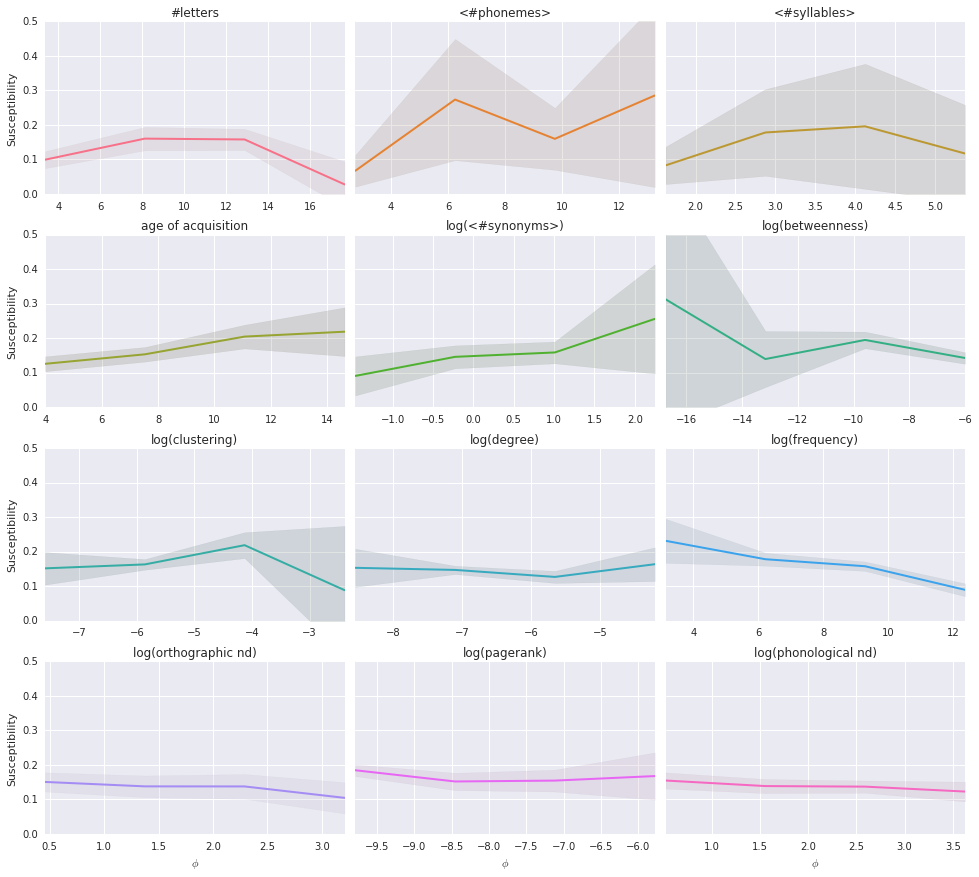

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

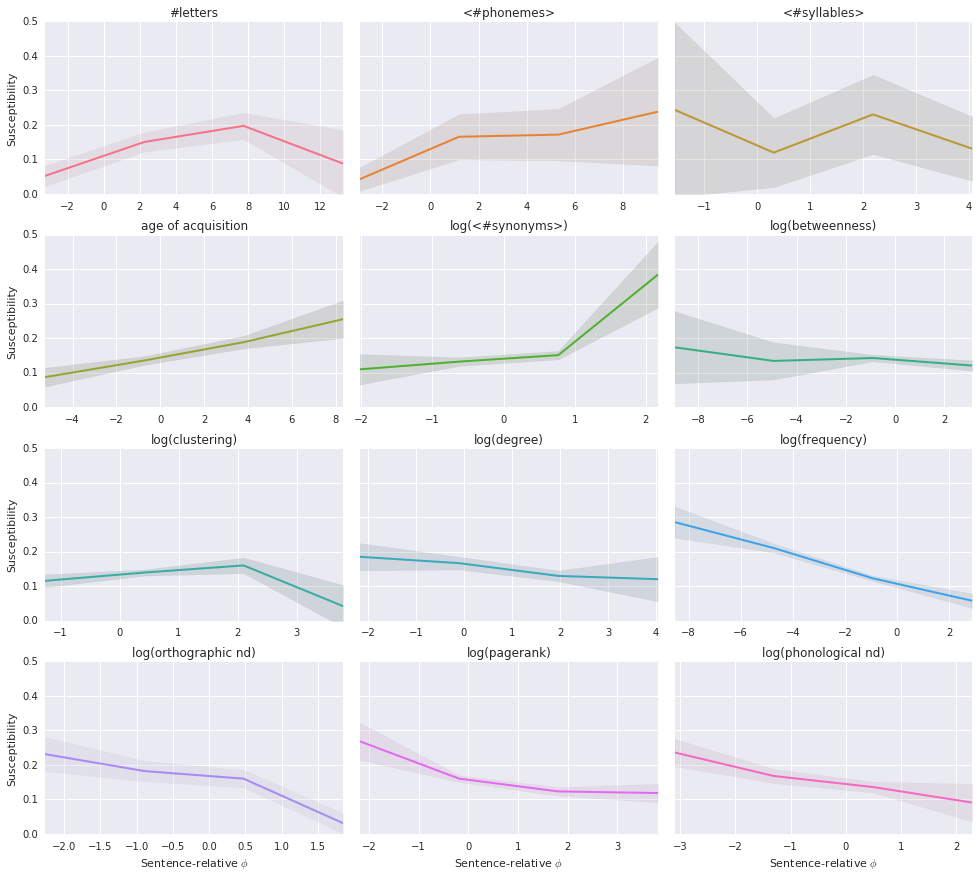

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

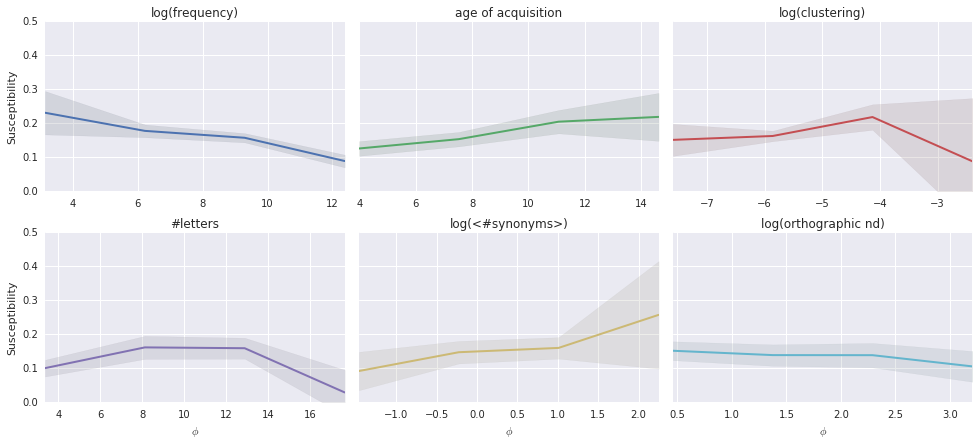

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

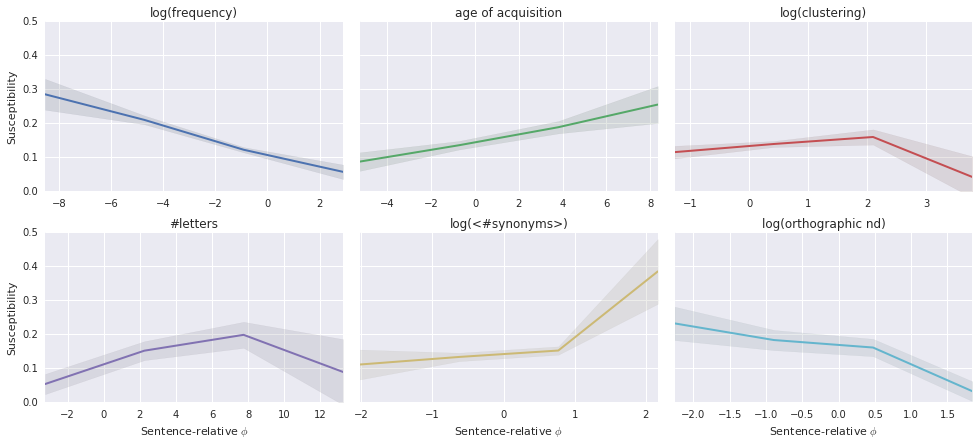

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

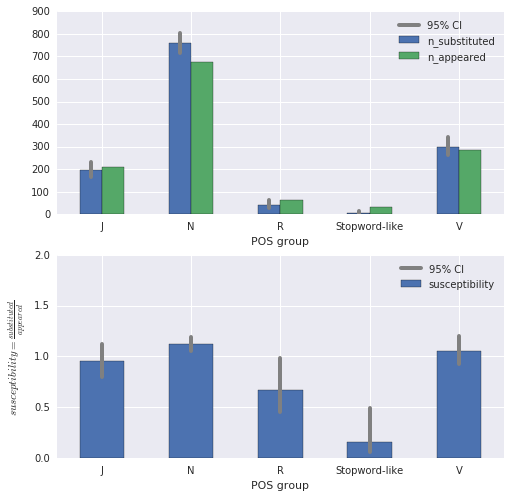

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

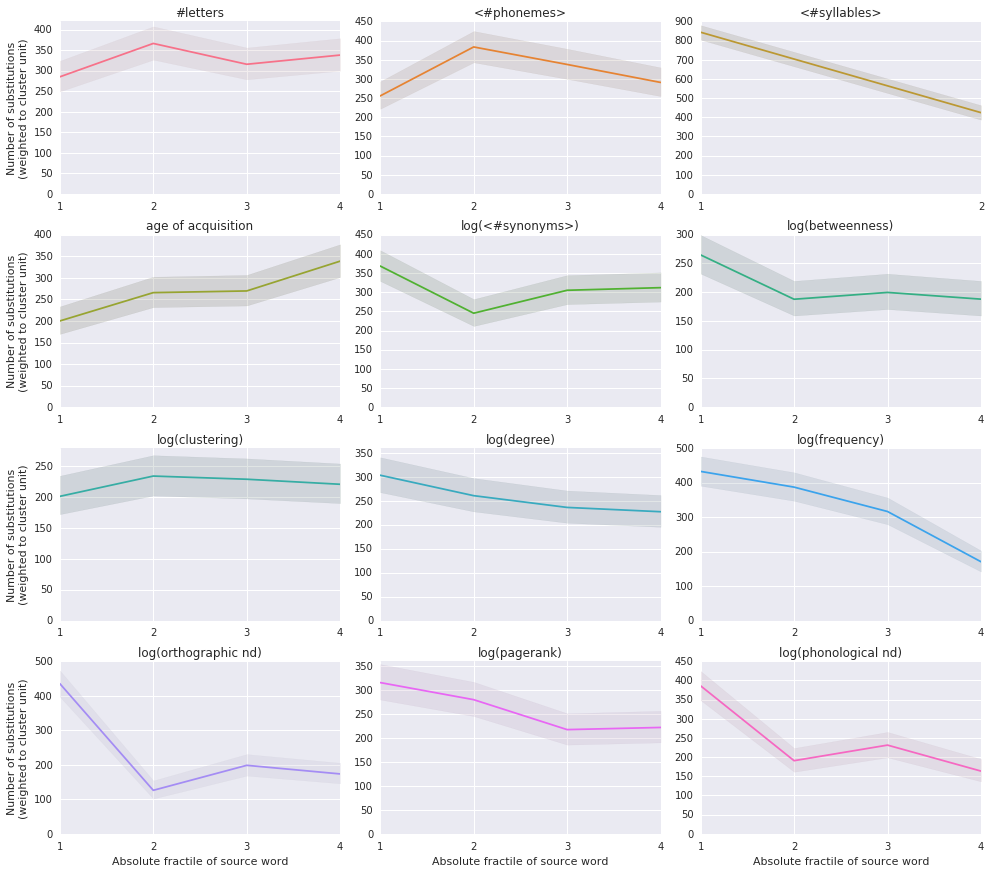

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

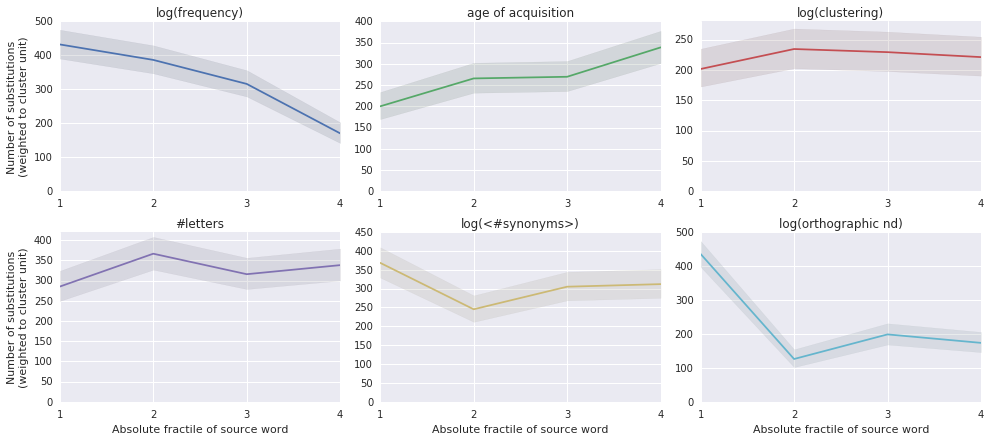

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  1% (  46 of 3641) |                      | Elapsed Time: 0:00:00 ETA:  0:00:40

  2% (  92 of 3641) |                      | Elapsed Time: 0:00:00 ETA:  0:00:36

  3% ( 137 of 3641) |                      | Elapsed Time: 0:00:01 ETA:  0:00:37

  5% ( 183 of 3641) |#                     | Elapsed Time: 0:00:01 ETA:  0:00:37

  6% ( 228 of 3641) |#                     | Elapsed Time: 0:00:02 ETA:  0:00:37

  7% ( 274 of 3641) |#                     | Elapsed Time: 0:00:03 ETA:  0:00:37

  8% ( 319 of 3641) |#                     | Elapsed Time: 0:00:03 ETA:  0:00:37

 10% ( 365 of 3641) |##                    | Elapsed Time: 0:00:03 ETA:  0:00:35

 11% ( 410 of 3641) |##                    | Elapsed Time: 0:00:04 ETA:  0:00:35

 12% ( 456 of 3641) |##                    | Elapsed Time: 0:00:04 ETA:  0:00:34

 13% ( 501 of 3641) |###                   | Elapsed Time: 0:00:05 ETA:  0:00:34

 15% ( 547 of 3641) |###                   | Elapsed Time: 0:00:05 ETA:  0:00:32

 16% ( 592 of 3641) |###                   | Elapsed Time: 0:00:06 ETA:  0:00:32

 17% ( 638 of 3641) |###                   | Elapsed Time: 0:00:06 ETA:  0:00:31

 18% ( 683 of 3641) |####                  | Elapsed Time: 0:00:07 ETA:  0:00:29

 20% ( 729 of 3641) |####                  | Elapsed Time: 0:00:07 ETA:  0:00:28

 21% ( 774 of 3641) |####                  | Elapsed Time: 0:00:08 ETA:  0:00:28

 22% ( 820 of 3641) |####                  | Elapsed Time: 0:00:08 ETA:  0:00:27

 23% ( 865 of 3641) |#####                 | Elapsed Time: 0:00:09 ETA:  0:00:27

 25% ( 911 of 3641) |#####                 | Elapsed Time: 0:00:09 ETA:  0:00:26

 26% ( 956 of 3641) |#####                 | Elapsed Time: 0:00:10 ETA:  0:00:26

 27% (1002 of 3641) |######                | Elapsed Time: 0:00:10 ETA:  0:00:25

 28% (1047 of 3641) |######                | Elapsed Time: 0:00:10 ETA:  0:00:25

 30% (1093 of 3641) |######                | Elapsed Time: 0:00:11 ETA:  0:00:25

 31% (1138 of 3641) |######                | Elapsed Time: 0:00:11 ETA:  0:00:26

 32% (1184 of 3641) |#######               | Elapsed Time: 0:00:12 ETA:  0:00:25

 33% (1229 of 3641) |#######               | Elapsed Time: 0:00:12 ETA:  0:00:25

 35% (1275 of 3641) |#######               | Elapsed Time: 0:00:13 ETA:  0:00:24

 36% (1320 of 3641) |#######               | Elapsed Time: 0:00:13 ETA:  0:00:24

 37% (1366 of 3641) |########              | Elapsed Time: 0:00:14 ETA:  0:00:23

 38% (1411 of 3641) |########              | Elapsed Time: 0:00:14 ETA:  0:00:23

 40% (1457 of 3641) |########              | Elapsed Time: 0:00:15 ETA:  0:00:23

 41% (1502 of 3641) |#########             | Elapsed Time: 0:00:15 ETA:  0:00:23

 42% (1548 of 3641) |#########             | Elapsed Time: 0:00:16 ETA:  0:00:21

 43% (1593 of 3641) |#########             | Elapsed Time: 0:00:16 ETA:  0:00:21

 45% (1639 of 3641) |#########             | Elapsed Time: 0:00:17 ETA:  0:00:21

 46% (1684 of 3641) |##########            | Elapsed Time: 0:00:17 ETA:  0:00:20

 47% (1730 of 3641) |##########            | Elapsed Time: 0:00:18 ETA:  0:00:20

 48% (1775 of 3641) |##########            | Elapsed Time: 0:00:18 ETA:  0:00:20

 50% (1821 of 3641) |###########           | Elapsed Time: 0:00:19 ETA:  0:00:20

 51% (1867 of 3641) |###########           | Elapsed Time: 0:00:19 ETA:  0:00:19

 52% (1912 of 3641) |###########           | Elapsed Time: 0:00:20 ETA:  0:00:18

 53% (1958 of 3641) |###########           | Elapsed Time: 0:00:20 ETA:  0:00:18

 55% (2003 of 3641) |############          | Elapsed Time: 0:00:21 ETA:  0:00:17

 56% (2049 of 3641) |############          | Elapsed Time: 0:00:21 ETA:  0:00:16

 57% (2094 of 3641) |############          | Elapsed Time: 0:00:21 ETA:  0:00:15

 58% (2140 of 3641) |############          | Elapsed Time: 0:00:22 ETA:  0:00:14

 60% (2185 of 3641) |#############         | Elapsed Time: 0:00:22 ETA:  0:00:14

 61% (2231 of 3641) |#############         | Elapsed Time: 0:00:23 ETA:  0:00:13

 62% (2276 of 3641) |#############         | Elapsed Time: 0:00:23 ETA:  0:00:13

 63% (2322 of 3641) |##############        | Elapsed Time: 0:00:24 ETA:  0:00:12

 65% (2367 of 3641) |##############        | Elapsed Time: 0:00:24 ETA:  0:00:12

 66% (2413 of 3641) |##############        | Elapsed Time: 0:00:25 ETA:  0:00:11

 67% (2458 of 3641) |##############        | Elapsed Time: 0:00:25 ETA:  0:00:11

 68% (2504 of 3641) |###############       | Elapsed Time: 0:00:26 ETA:  0:00:11

 70% (2549 of 3641) |###############       | Elapsed Time: 0:00:26 ETA:  0:00:11

 71% (2595 of 3641) |###############       | Elapsed Time: 0:00:27 ETA:  0:00:10

 72% (2640 of 3641) |###############       | Elapsed Time: 0:00:27 ETA:  0:00:09

 73% (2686 of 3641) |################      | Elapsed Time: 0:00:28 ETA:  0:00:09

 75% (2731 of 3641) |################      | Elapsed Time: 0:00:29 ETA:  0:00:15

 76% (2777 of 3641) |################      | Elapsed Time: 0:00:29 ETA:  0:00:14

 77% (2822 of 3641) |#################     | Elapsed Time: 0:00:30 ETA:  0:00:14

 78% (2868 of 3641) |#################     | Elapsed Time: 0:00:30 ETA:  0:00:14

 80% (2913 of 3641) |#################     | Elapsed Time: 0:00:31 ETA:  0:00:13

 81% (2959 of 3641) |#################     | Elapsed Time: 0:00:31 ETA:  0:00:13

 82% (3004 of 3641) |##################    | Elapsed Time: 0:00:32 ETA:  0:00:13

 83% (3050 of 3641) |##################    | Elapsed Time: 0:00:32 ETA:  0:00:13

 85% (3095 of 3641) |##################    | Elapsed Time: 0:00:33 ETA:  0:00:05

 86% (3141 of 3641) |##################    | Elapsed Time: 0:00:33 ETA:  0:00:05

 87% (3186 of 3641) |###################   | Elapsed Time: 0:00:34 ETA:  0:00:04

 88% (3232 of 3641) |###################   | Elapsed Time: 0:00:34 ETA:  0:00:03

 90% (3277 of 3641) |###################   | Elapsed Time: 0:00:34 ETA:  0:00:02

 91% (3323 of 3641) |####################  | Elapsed Time: 0:00:35 ETA:  0:00:02

 92% (3368 of 3641) |####################  | Elapsed Time: 0:00:35 ETA:  0:00:01

 93% (3414 of 3641) |####################  | Elapsed Time: 0:00:36 ETA:  0:00:00

 95% (3459 of 3641) |####################  | Elapsed Time: 0:00:36 ETA:  0:00:00

 96% (3505 of 3641) |##################### | Elapsed Time: 0:00:37 ETA:  0:00:00

 97% (3550 of 3641) |##################### | Elapsed Time: 0:00:37 ETA:  0:00:00

 98% (3596 of 3641) |##################### | Elapsed Time: 0:00:38 ETA:  0:00:00

100% (3641 of 3641) |######################| Elapsed Time: 0:00:38 Time: 0:00:38


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

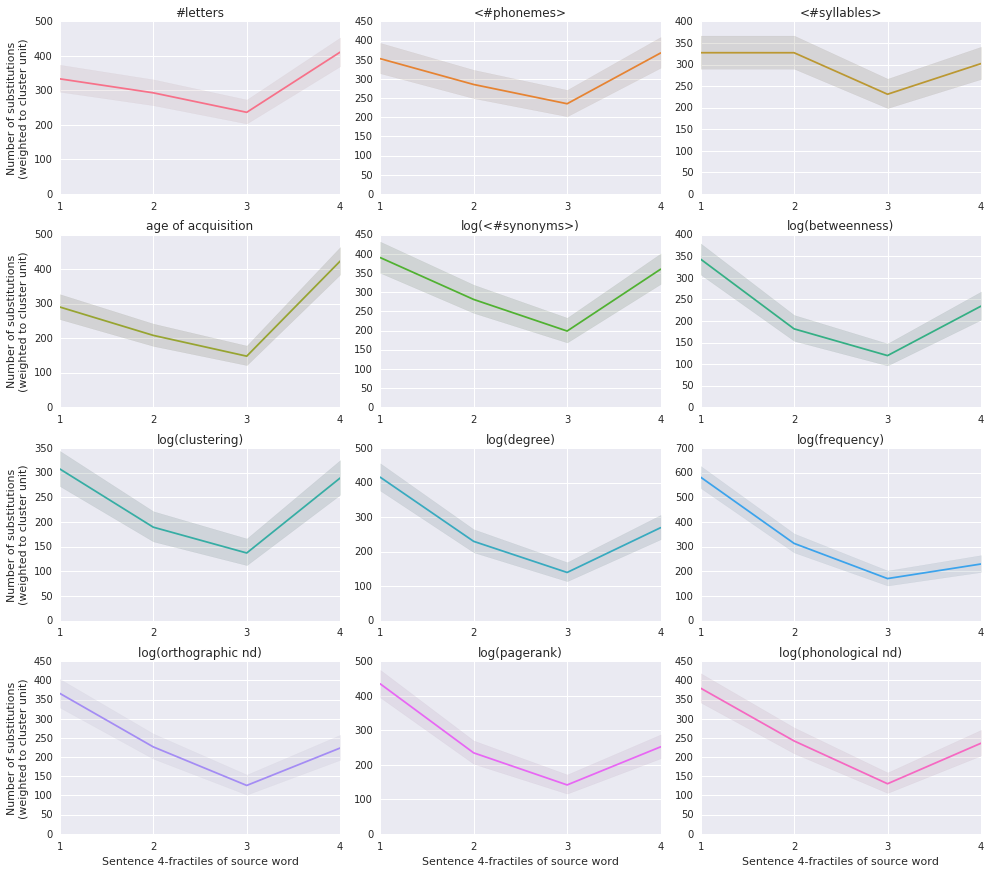

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

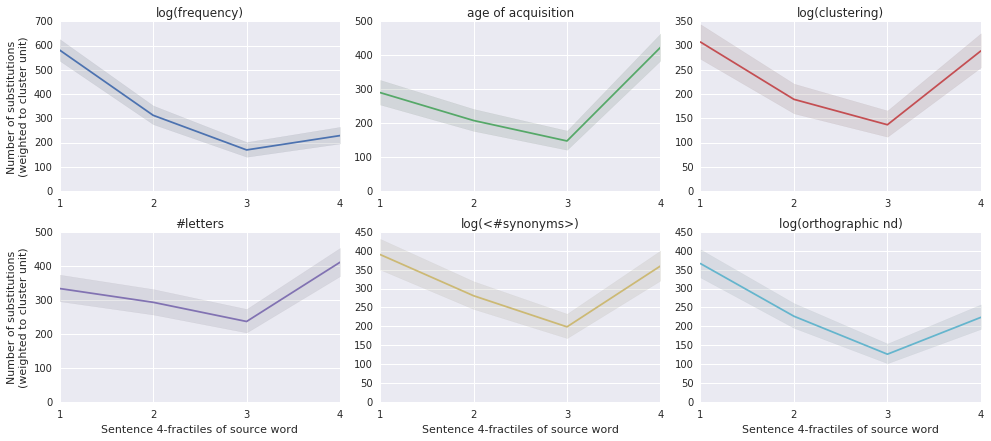

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)